In [1]:
# **1. Setup and Imports**
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
# **2. Load and Preprocess Data**
# Load dataset
df = pd.read_csv('address_data_combined_ts.csv')

# Remove rows where all 12 feature columns after 'Address' and 'FLAG' are zero
df = df[~((df.iloc[:, 2:14] == 0).all(axis=1))]

# Print dataset structure to check balance
print("Dataset Structure After Removal:")
print(df['FLAG'].value_counts())

Dataset Structure After Removal:
FLAG
0    7637
1    4616
Name: count, dtype: int64


In [3]:
# **3. Feature Engineering**
# Define features and target
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']

# Log transform specified columns
log_transform_columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract)',
       'total ether received']

for c in log_transform_columns:
    X[c] = X[c].apply(lambda x: np.log(x) if x > 0 else 0)

In [4]:
# **4. Train-Test Split & Class Weight Calculation**
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle missing values
np.isnan(X_train)

# Compute class weight dynamically
class_counts = df['FLAG'].value_counts()
scale_pos_weight = class_counts.get(0, 1) / class_counts.get(1, 1)  # Handles missing values safely

# Print calculated scale_pos_weight
print("Calculated scale_pos_weight:", scale_pos_weight)


Calculated scale_pos_weight: 1.6544627383015598


In [10]:
# **5. Model Initialization & Hyperparameter Tuning**
# Initialize XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',
    seed=42,
    scale_pos_weight=scale_pos_weight,
    # tree_method='hist',
    device='cuda'
)

# Define hyperparameter grid
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(800,1200,100),
    'learning_rate': [0.1, 0.01, 0.05]
}

# Perform Grid Search
tuned_clf = GridSearchCV(estimator=xgb,
                         param_grid=param_grid,
                         scoring='f1',
                         cv=5,
                         verbose=2)
tuned_clf.fit(X_train, y_train)

# Get best model
best_model = tuned_clf.best_estimator_

# Print best hyperparameters
print("Best Hyperparameters:", tuned_clf.best_params_)
print("Best F1 Score from Grid Search:", tuned_clf.best_score_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=800; total time=   2.1s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=800; total time=   1.0s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=800; total time=   0.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=800; total time=   0.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=800; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=900; total time=   1.0s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=900; total time=   0.9s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=900; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=900; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=900; total time=   0.7s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   0.8s
[CV] END ..learning_rate=0.1, max_depth=2, n_es

In [12]:
# **6. Model Evaluation**
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("Train F1 Score:", train_f1)
print("Test F1 Score:", test_f1)
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)


Train F1 Score: 0.9781647689216343
Test F1 Score: 0.9133942980096826
Accuracy: 0.934312525499796
ROC AUC Score: 0.9314447397230747
Confusion Matrix:
 [[1441   87]
 [  74  849]]


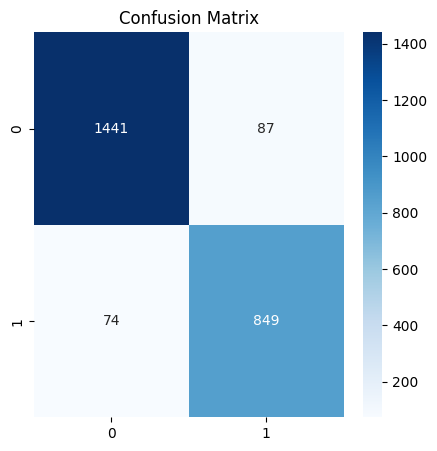

Model Confusion Matrix Statistics:
recall: 0.9198
false_neg_rate: 0.0802
false_pos_rate: 0.0569
true_neg_rate: 0.9431
positive_likelihood_ratio: 16.1551
negative_likelihood_ratio: 0.0850
precision: 0.9071
false_omission_rate: 0.0488
false_discovery_rate: 0.0929
negative_pred_value: 0.9512
markedness: 0.8582
diagnostic_odds_ratio: 190.0294
informedness: 0.8629
prevalence_threshold: 0.1992
prevalence: 0.3766
accuracy: 0.9343
balanced_accuracy: 0.9314
F1_score: 0.9134
fowlkes_mallows_index: 0.9134
jaccard_index: 0.8406


In [13]:
# **7. Model Diagnostic Statistics**
def model_diagnostic_stats(confusion_matrix):
    tp = confusion_matrix[1,1]
    tn = confusion_matrix[0,0]
    fp = confusion_matrix[0,1]
    fn = confusion_matrix[1,0]

    p = tp + fn
    n = fp + tn
    pp = tp + fp
    pn = fn + tn

    diagnostic_dict = {
        'recall' : tp/p,
        'false_neg_rate' : fn/p,
        'false_pos_rate' : fp/n,
        'true_neg_rate' : tn/n,
        'positive_likelihood_ratio' : (tp/p)/(fp/n),
        'negative_likelihood_ratio' : (fn/p)/(tn/n),
        'precision' : tp/pp,
        'false_omission_rate' : fn/pn,
        'false_discovery_rate' : fp/pp,
        'negative_pred_value' : tn/pn,
        'markedness' : (tp/pp)+(tn/pn)-1,
        'diagnostic_odds_ratio' : ((tp/p)/(fp/n))/((fn/p)/(tn/n)),
        'informedness' : (tp/p)+(tn/n)-1,
        'prevalence_threshold' : (np.sqrt((tp/p)*(fp/n))-(fp/n))/((tp/p)-(fp/n)),
        'prevalence' : p/(p+n),
        'accuracy' : (tp+tn)/(p+n),
        'balanced_accuracy' : ((tp/p)+(tn/n))/2,
        'F1_score' : 2*tp/(2*tp+fp+fn),
        'fowlkes_mallows_index' : np.sqrt((tp/pp)*(tp/p)),
        'jaccard_index' : tp/(tp+fn+fp),
    }
    return diagnostic_dict

# Compute and display confusion matrix statistics
cm_matrix = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(5,5))
sb.heatmap(cm_matrix, annot=True, fmt='g', cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

stats = model_diagnostic_stats(cm_matrix)
print('Model Confusion Matrix Statistics:')
for key, value in stats.items():
    print(f"{key}: {value:.4f}")


<Figure size 1000x500 with 0 Axes>

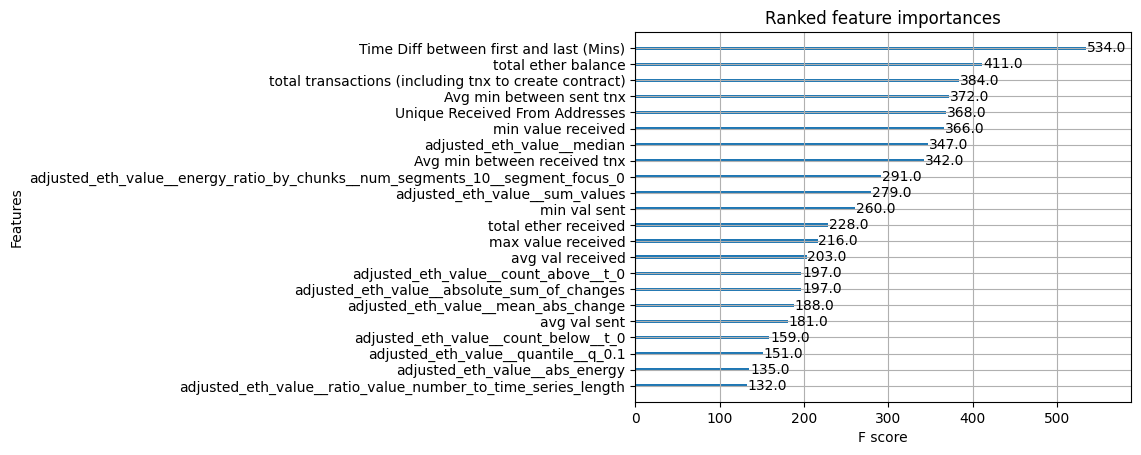

In [14]:
# **8. Feature Importance Visualization**
plt.figure(figsize=(10,5))
plot_importance(best_model)
plt.title("Ranked feature importances")
plt.show()


In [15]:
# **9. Save Model and Pipeline**
import joblib

# Save the trained XGBoost model
joblib.dump(best_model, 'xgboost_fraud_model.pkl')

# Save the preprocessing pipeline (log transforms)
def preprocess_pipeline(df):
    # Drop Address and FLAG as they are not features
    df = df.drop(columns=['Address', 'FLAG'], errors='ignore')

    # Apply log transform to relevant columns
    log_transform_columns = ['Avg min between sent tnx', 'Avg min between received tnx',
        'Time Diff between first and last (Mins)', 'Unique Received From Addresses',
        'min value received', 'max value received', 'avg val received',
        'min val sent', 'avg val sent',
        'total transactions (including tnx to create contract)', 'total ether received']

    for c in log_transform_columns:
        df[c] = df[c].apply(lambda x: np.log(x) if x > 0 else 0)

    return df

# Save the preprocessing function
joblib.dump(preprocess_pipeline, 'preprocess_pipeline.pkl')

print("Model and preprocessing pipeline saved successfully!")


Model and preprocessing pipeline saved successfully!


In [43]:
# **10. Evaluate Model on a Synthetic Fraud Case**
import joblib

# Load saved model and preprocessing pipeline
model = joblib.load('xgboost_fraud_model.pkl')
preprocess_pipeline = joblib.load('preprocess_pipeline.pkl')

# Define a synthetic fraud case
synthetic_fraud_case = pd.DataFrame([{
    'Address': '0xFakeAddress123',
    'FLAG': 1,  # Actual fraud label
    'Avg min between sent tnx': 50,
    'Avg min between received tnx': 30,
    'Time Diff between first and last (Mins)': 5000,
    'Unique Received From Addresses': 15,
    'min value received': 0.01,
    'max value received': 5,
    'avg val received': 0.5,
    'min val sent': 0.001,
    'avg val sent': 0.3,
    'total transactions (including tnx to create contract)': 45,
    'total ether received': 10,
    'total ether balance': 3,
    'adjusted_eth_value__absolute_sum_of_changes': 1.2,
    'adjusted_eth_value__mean_abs_change': 0.5,
    'adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0': 0.6,
    'adjusted_eth_value__sum_values': 5,
    'adjusted_eth_value__abs_energy': 10,
    'adjusted_eth_value__ratio_value_number_to_time_series_length': 0.8,
    'adjusted_eth_value__quantile__q_0.1': 0.2,
    'adjusted_eth_value__count_below__t_0': 3,
    'adjusted_eth_value__count_above__t_0': 7,
    'adjusted_eth_value__median': 0.4
}])

# Apply preprocessing (removes Address & FLAG, applies log transforms)
processed_case = preprocess_pipeline(synthetic_fraud_case)

# Predict fraud probability and class
predicted_flag = model.predict(processed_case)[0]
predicted_prob = model.predict_proba(processed_case)[:, 1][0]

# Print results
print(f"Actual FLAG: {synthetic_fraud_case['FLAG'][0]}")
print(f"Predicted FLAG: {predicted_flag}")
print(f"Fraud Probability: {predicted_prob:.4f}")


Actual FLAG: 1
Predicted FLAG: 1
Fraud Probability: 0.9760


In [49]:
# **10. Evaluate Model on a Synthetic Fraud Case**
import joblib

# Load saved model and preprocessing pipeline
model = joblib.load('xgboost_fraud_model.pkl')
preprocess_pipeline = joblib.load('preprocess_pipeline.pkl')

# Define a synthetic fraud case
synthetic_fraud_case = pd.DataFrame([{
    'Address': '0xFakeAddress4',
    'FLAG': 1,
    'Avg min between sent tnx': 20,
    'Avg min between received tnx': 20,
    'Time Diff between first and last (Mins)': 450,
    'Unique Received From Addresses': 30,
    'min value received': 0.15,
    'max value received': 4,
    'avg val received': 1.5,
    'min val sent': 0.08,
    'avg val sent': 0.8,
    'total transactions (including tnx to create contract)': 75,
    'total ether received': 150,
    'total ether balance': 120,
    'adjusted_eth_value__absolute_sum_of_changes': 40,
    'adjusted_eth_value__mean_abs_change': 0.4,
    'adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0': 0.25,
    'adjusted_eth_value__sum_values': 750,
    'adjusted_eth_value__abs_energy': 150,
    'adjusted_eth_value__ratio_value_number_to_time_series_length': 0.15,
    'adjusted_eth_value__quantile__q_0.1': 0.08,
    'adjusted_eth_value__count_below__t_0': 8,
    'adjusted_eth_value__count_above__t_0': 67,
    'adjusted_eth_value__median': 1.2
}])

# Apply preprocessing (removes Address & FLAG, applies log transforms)
processed_case = preprocess_pipeline(synthetic_fraud_case)

# Predict fraud probability and class
predicted_flag = model.predict(processed_case)[0]
predicted_prob = model.predict_proba(processed_case)[:, 1][0]

# Print results
print(f"Actual FLAG: {synthetic_fraud_case['FLAG'][0]}")
print(f"Predicted FLAG: {predicted_flag}")
print(f"Fraud Probability: {predicted_prob:.4f}")


Actual FLAG: 1
Predicted FLAG: 1
Fraud Probability: 0.9001


Actual FLAG: 1
Predicted FLAG: 0
Fraud Probability: 0.1782
